# [랜덤포레스트]
유방암 결과를 분류하는 랜덤 포레스트 모델을 만들고 predict method 를 이용하여 목표변수 범주를 예측하라. 그리고 모델의 정확도 confusion matrix 를 구하라.
## 1. 데이터 구성하기

In [2]:
#패키지 불러오기

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl

from sklearn.model_selection import train_test_split

from sklearn.tree import export_graphviz

import graphviz

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

#경고창 제거
import warnings
warnings.filterwarnings('ignore')

#한글 적용
from matplotlib import font_manager, rc
import matplotlib.font_manager as fm
mpl.rc('font',family= 'Malgun Gothic')
font_manager.get_fontconfig_fonts()
fontname = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontname = font_manager.FontProperties(fname=fontname).get_name()
plt.style.use('seaborn-white')
rc('font', family=fontname)

In [6]:
df_raw = pd.read_csv('/home/pirl/Downloads/data2/유방암.csv')
df_raw.head()

,diagnosis,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


diagnosis : 0(악성), 1(양성)

In [4]:
#결측치 확인
df_raw.isnull().sum()

diagnosis                  0
mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

결측치는 없다.

In [7]:
df_raw.shape

(569, 31)

In [11]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
diagnosis                  569 non-null int64
mean radius                569 non-null float64
mean texture               569 non-null float64
mean perimeter             569 non-null float64
mean area                  569 non-null float64
mean smoothness            569 non-null float64
mean compactness           569 non-null float64
mean concavity             569 non-null float64
mean concave points        569 non-null float64
mean symmetry              569 non-null float64
mean fractal dimension     569 non-null float64
radius error               569 non-null float64
texture error              569 non-null float64
perimeter error            569 non-null float64
area error                 569 non-null float64
smoothness error           569 non-null float64
compactness error          569 non-null float64
concavity error            569 non-null float64
concave points error       569 no

설명변수의 자료구조 중 범주형은 없으므로 더미변수 생성은 하지 않아도 된다.

In [12]:
# 목표변수, 설명변수 데이터 지정
df_raw_y = df_raw['diagnosis']
df_raw_x = df_raw.drop('diagnosis', axis=1, inplace=False)

#데이터 분할하기
df_train_x1,df_test_x,df_train_y1,df_test_y = train_test_split(df_raw_x,df_raw_y,
                                                              test_size=0.3, random_state=1234)
df_train_x,df_val_x,df_train_y,df_val_y = train_test_split(df_train_x1,df_train_y1,
                                                          test_size=3/7, random_state=1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("validation data X size : {}".format(df_val_x.shape))
print("validation data Y size : {}".format(df_val_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (227, 30)
train data Y size : (227,)
validation data X size : (171, 30)
validation data Y size : (171,)
test data X size : (171, 30)
test data Y size : (171,)


## 2. 모델 생성

In [13]:
#기본옵션으로 모델 생성
rf_uncustomized = RandomForestClassifier(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)

print('Accuracy on training set:{:.3f}'.format(rf_uncustomized.score(df_train_x,df_train_y)))
print('Accuracy on validation set:{:.3f}'.format(rf_uncustomized.score(df_val_x,df_val_y)))

Accuracy on training set:0.996
Accuracy on validation set:0.953


In [14]:
#현재 생성된 랜덤 포레스트 모델의 옵션 확인
rf_uncustomized

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

**train 데이터의 정확도가 매우 높다 (99.6%) : 과대적합**

In [16]:
##모델 parameter 조정
#n_estimators : 트리 수 변경에 따른 모델 성능

train_accuracy = []; val_accuracy = []

para_n_tree = [n_tree * 10 for n_tree in range(1,16)]

for v_n_estimators in para_n_tree:
    rf=RandomForestClassifier(n_estimators=v_n_estimators, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    val_accuracy.append(rf.score(df_val_x, df_val_y))

df_accuracy_n = pd.DataFrame()
df_accuracy_n['n_estimators'] = para_n_tree
df_accuracy_n['TrainAccuracy'] = train_accuracy
df_accuracy_n['ValidationAccuracy'] = val_accuracy

In [17]:
df_accuracy_n.round(3)

,n_estimators,TrainAccuracy,ValidationAccuracy
0,10,0.996,0.953
1,20,0.996,0.953
2,30,1.000,0.953
3,40,1.000,0.953
4,50,1.000,0.947
5,60,1.000,0.953
6,70,1.000,0.953
7,80,1.000,0.953
8,90,1.000,0.953
9,100,1.000,0.953


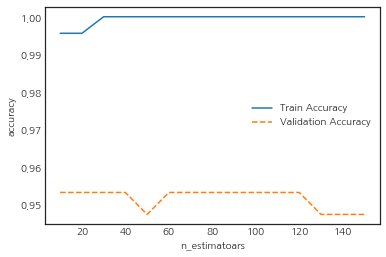

In [19]:
plt.plot(para_n_tree, train_accuracy, linestyle='-', label='Train Accuracy')
plt.plot(para_n_tree, val_accuracy, linestyle='--', label='Validation Accuracy')
plt.xlabel('n_estimatoars'); plt.ylabel('accuracy')
plt.legend()

생성하는 결정 트리 수 증가에 따라 모델의 정확도는 증가하며 train/test 데이터의 성능 변화를 고려하여 40을 선택한다.

In [20]:
#max_depth : 최대 깊이 변경에 따른 모델 성능

train_accuracy = []; val_accuracy = []

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    rf=RandomForestClassifier(max_depth = v_max_depth, n_estimators = 40, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    val_accuracy.append(rf.score(df_val_x, df_val_y))

df_accuracy_depth = pd.DataFrame()
df_accuracy_depth['Depth'] = para_depth
df_accuracy_depth['TrainAccuracy'] = train_accuracy
df_accuracy_depth['ValidationAccuracy'] = val_accuracy

In [21]:
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,ValidationAccuracy
0,1,0.938,0.930
1,2,0.978,0.936
2,3,0.987,0.947
3,4,0.996,0.953
4,5,0.996,0.953
5,6,1.000,0.953
6,7,1.000,0.953
7,8,1.000,0.953
8,9,1.000,0.953
9,10,1.000,0.953


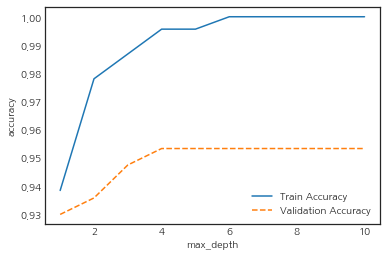

In [22]:
plt.plot(para_depth, train_accuracy, linestyle='-', label='Train Accuracy')
plt.plot(para_depth, val_accuracy, linestyle='--', label='Validation Accuracy')
plt.xlabel('max_depth'); plt.ylabel('accuracy')
plt.legend()

최대 깊이 증가에 따라 모델의 정확도는 증가하며 train/test 데이터의 성능 변화를 고려하여 4를 선택한다.

In [23]:
#min_samples_split : 분리 노드의 최소 자료 수 변경에 따른 모델 성능

train_accuracy =[]; val_accuracy = []

para_split = [n_split * 10 for n_split in range(1,11)]

for v_min_samples_split in para_split :
    rf=RandomForestClassifier(min_samples_split = v_min_samples_split, max_depth=4,
                             n_estimators=40, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    val_accuracy.append(rf.score(df_val_x,df_val_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split['MinSamplesSplit'] = para_split
df_accuracy_split['TrainAccuracy'] = train_accuracy
df_accuracy_split['ValidationAccuracy'] = val_accuracy

In [24]:
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,ValidationAccuracy
0,10,0.991,0.947
1,20,0.987,0.947
2,30,0.982,0.942
3,40,0.982,0.942
4,50,0.982,0.942
5,60,0.978,0.936
6,70,0.974,0.947
7,80,0.974,0.947
8,90,0.978,0.942
9,100,0.974,0.942


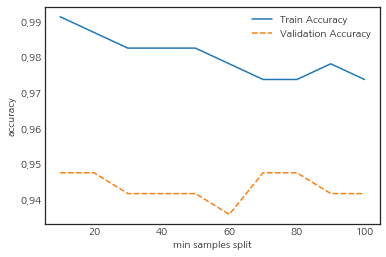

In [27]:
plt.plot(para_split, train_accuracy, linestyle='-', label='Train Accuracy')
plt.plot(para_split, val_accuracy, linestyle='--', label='Validation Accuracy')
plt.xlabel('min samples split'); plt.ylabel('accuracy')
plt.legend()

분리 노드의 최소 자료 수 증가에 따라 모델의 정확도는 감소하나 test의 성능 변화를 고려하여 50을 선택한다.

In [28]:
#min_ssamples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

train_accuracy =[]; val_accuracy =[]

para_leaf = [n_leaf * 10 for n_leaf in range(1,11)]

for v_min_samples_leaf in para_leaf:
    rf=RandomForestClassifier(min_samples_leaf = v_min_samples_leaf,min_samples_split=50,
                             max_depth =4, n_estimators =40, random_state=1234)
    rf.fit(df_train_x,df_train_y)
    train_accuracy.append(rf.score(df_train_x,df_train_y))
    val_accuracy.append(rf.score(df_val_x,df_val_y))

df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf['MinSamplesLeaf'] = para_leaf
df_accuracy_leaf['TrainAccuracy'] = train_accuracy
df_accuracy_leaf['ValidationAccuracy'] = val_accuracy

In [29]:
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,ValidationAccuracy
0,10,0.978,0.947
1,20,0.965,0.959
2,30,0.943,0.953
3,40,0.956,0.953
4,50,0.943,0.965
5,60,0.925,0.947
6,70,0.916,0.936
7,80,0.630,0.637
8,90,0.630,0.637
9,100,0.630,0.637


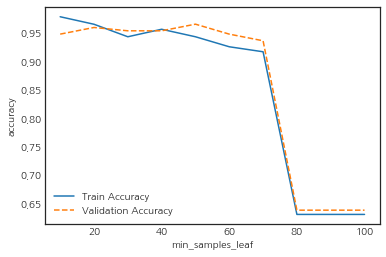

In [30]:
plt.plot(para_leaf, train_accuracy, linestyle='-', label="Train Accuracy" )
plt.plot(para_leaf, val_accuracy, linestyle='--', label="Validation Accuracy" )
plt.xlabel('min_samples_leaf'); plt.ylabel('accuracy')
plt.legend()

잎사귀 노드 최소 자료 수 증가에 따라 모델의 정확도는 감소하며 train/test데이터의 성능 변화를 고려하여 20을 선택한다.

## 3. 결론 도출

In [33]:
#최종모델
rf_final = RandomForestClassifier(min_samples_leaf = 40, min_samples_split = 50, max_depth=4,
                                 n_estimators=40, random_state=1234)
rf_final.fit(df_train_x, df_train_y)
y_pred = rf_final.predict(df_test_x)

print('Accuracy on training set:{:.3f}'.format(rf_final.score(df_train_x,df_train_y)))
print('Accuracy on test set:{:.3f}'.format(rf_final.score(df_test_x,df_test_y)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(df_test_y,y_pred)))

Accuracy on training set:0.956
Accuracy on test set:0.918
Confusion Matrix:
[[103   2]
 [ 12  54]]


In [34]:
#설명변수의 중요도
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rf_final.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
6,mean concavity,0.172
22,worst perimeter,0.157
20,worst radius,0.144
27,worst concave points,0.099
23,worst area,0.098
7,mean concave points,0.055
2,mean perimeter,0.049
3,mean area,0.048
17,concave points error,0.044
5,mean compactness,0.029


Text(0, 0.5, '설명변수')

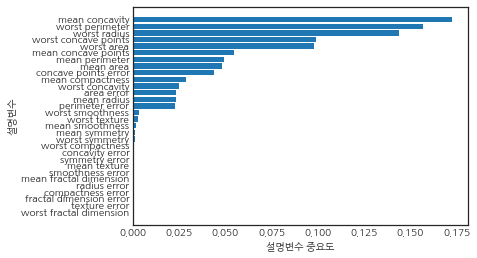

In [35]:
df_importance.sort_values('Importance', ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')

In [40]:
#추가적으로 GridSearchCV를 이용한 최적의 parameter 찾기
estimator = RandomForestClassifier(n_estimators=100, random_state=1234)
param_grid = {'max_depth':para_depth, 'min_samples_leaf':para_leaf}
grid_rf = GridSearchCV(estimator, param_grid,scoring='accuracy', n_jobs=-1)
grid_rf.fit(df_train_x, df_train_y)
print('best estimator model:\n{}'.format(grid_rf.best_estimator_))
print('\nbest parameter:\n{}'.format(grid_rf.best_params_))
print('\nbest score:\n{}'.format(grid_rf.best_score_.round(3)))

best estimator model:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

best parameter:
{'max_depth': 2, 'min_samples_leaf': 10}

best score:
0.952


### @결과 해석@
### 변수의 중요도

**1. 오목함, 종양 둘레, 종양 반경 순으로 설명변수의 영향도가 크다고 해석할 수 있다.**


**2. (단, 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 데이터에 따라 중요도가 변경될 수 있다.)**


**3. 따라서, 오목함, 종양 둘레, 그리고 반경에 따라 암진단에 많은 영향을 준다고 할 수 있다.**

**4. 또한 그 중요도가 모두 양수이므로 오목함의 평균 값이 클수록, 둘레가 클수록, 반경이 클수록 양성(1)일 확률이 증가한다고 해석할 수 있다.**



### 모델

**1. 기본 옵션으로 생성된 모델은 과대적합의 문제가 있어 parameter 조정을 실시한다.**


**2. 트리 수는 40, 최대 깊이는 4, 분리 노드의 최소 자료 수는 50, 잎사귀 노드의 최소 자료 수는 40개로 조정했다. 하지만 이것은 과대적합의 문제는 해결됐지만 기본 옵션보다 정확도가 훨씬 떨어진 91.8%가 나와 GridSearchCV를 이용한 최적의 parameter를 찾아보기로 한다.**


**3. 최적의 parameter 를 GridSearchCV를 이용하여 보게되면 최대 깊이가 2, 최소 샘플 수가 10일 때 정확도가 95.2%로 가장 높다. 하지만 암진단에 95.2%의 정확도를 갖는 모델을 사용하기에 위험성이 있어보인다. 따라서 현재 유방암 진단의 기술 수준에 대해 알아보본다.**

**4.  현재 유방암을 진단하는 '유방 MRI'는 유방암을 진단하는데 있어 여러 영상검사 중 가장 민감도(유방암이 있는 사람을 유방암이 있다고 판단하는 확률: 86%~100% 정도)가 높은 검사 방법으로 알려져있지만, 특이도(유방암이 없는 사람을 없다고 판단하는 확률)는 낮은 편이어서 유방을 전공하는 영상의학과 전문의에 의한 정확한 해석이 요구되는 검사이다. 따라서 현재 '유방MRI'검사는 민감도는 높더라도 특이도가 낮기때문에 정확도 측면에서는 떨어질 수 밖에 없다.**


**5. 최적의 랜덤포레스트 parameter의 정확도는 95.2%로 현재 유방MRI 기술의 정확도보다 높은 수준일 것이라고 예상된다. 따라서 전문의의 의사결정에 있어서 충분히 가치있는 분류모델로 활용될 수 있을 듯하다.**